In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch

import programs.conditions as cnd
import programs.NN as NN
import programs.visualize as vis
import programs.solvers as solv

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Gap width
w = 1.

# Proppant viscosity
mu0 = 0.1

# Maximum proppant concentration
cmax = 1.

# Influent proppant concentration
cin = 0.5

# Incoming flow rate
v_in = 0.1

# Mixture flow
Q0 = v_in*w

# Length of permeable area
chi = 0.4

# Width
H = 1.

# Length
L = 1.

# Number of randomly generated points for IC and BC
cond_points = 32

# Bounds for t,x,y
x_min, x_max, y_min, y_max, t_min, t_max = 0., L, 0., H, 0., 2
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Coordinates for IC and BC
x_range, y_range, t_range = torch.linspace(x_min, x_max, cond_points), torch.linspace(y_min, y_max, cond_points), torch.linspace(t_min, t_max, cond_points)
ranges = [x_range, y_range, t_range]

# Number of collocation points
collocation = 32

# Function describing the distribution of mixture flow along the perforation interval
# psi = np.where(np.abs(y_range - np.max(y_range) / 2) <= chi / 2, 1 / chi, 0)
# psi = torch.FloatTensor(psi).to(device)

zeros = torch.zeros(cond_points).to(device)
ones = torch.ones(cond_points).to(device)
cond = -12 * mu0 * v_in / w**2 * (1 - cin/cmax)**(-2.5)
c_condition = [[0, 0, cin, 0], [1, 1, 0, 1], [False, False, True, False]]
p_condition = [[0, 0, cond, cond], [1, 1, 1, 1], [False, False, True, True]]
print (cond, collocation**3, (1 - cin/cmax)**(-2.5))

-0.6788225099390858 32768 5.656854249492381


In [4]:
net = NN.Poisson_Convection(w=w, mu0=mu0, cmax=cmax, v_in=v_in, c_in=cin, chi=chi, c_cond=c_condition, p_cond=p_condition,
                            size=boundaries, collocation=collocation, cond_points=cond_points)

C:\Users\ilya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
# net.full_save("data/~good","data/~goodd")
net.full_load("data/ttt/0.25","data/ttt/0.25_data.npy")
# net.full_load("data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05","data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05_data.npy")

In [7]:
weights = [4,4,5,1,4]
net.weights = weights/np.max(weights)
print (net.weights)
# net.Adam_epochs = 5000
# net.train()
net.CL_epochs = [5000, 5000, 5000, 5000, 5000, 5000, 5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000,  5000, 5000]
parameters = {'w':[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]}
# parameters = {'w':[0.087, 0.077, 0.069, 0.055, 0.057, 0.052, 0.047, 0.043, 0.04, 0.037, 0.034, 0.0318, 0.025, 0.02, 0.015, 0.01]}
# parameters = {'w':[0.02, 0.015, 0.01]}
# parameters = {'w': }
net.CL_train(constants=parameters)
# net.full_save("data/vx=0.05chi=0.4","data/vx=0.05chi=0.4d")

[0.8 0.8 1.  0.2 0.8]
|       Epochs        |           PDE loss            |            IC loss            |            BC loss            |         Summary loss          |          w          |
|          0          |     0.0001632909115869552     |      0.2876043915748596       |      0.2424657642841339       |      0.5302334427833557       |          1          |
|         10          |    0.00017243792535737157     |     0.021195752546191216      |      0.16800084710121155      |      0.18936903774738312      |          1          |
|         20          |     0.000583605607971549      |     0.002713406691327691      |      0.16974547505378723      |      0.17304249107837677      |          1          |
|         30          |     0.000999737181700766      |     0.0035408977419137955     |      0.16407495737075806      |      0.16861559450626373      |          1          |
|         40          |     0.0014699118910357356     |     0.0033769248984754086     |      0.1614988446235

0.10501758754253387 26221


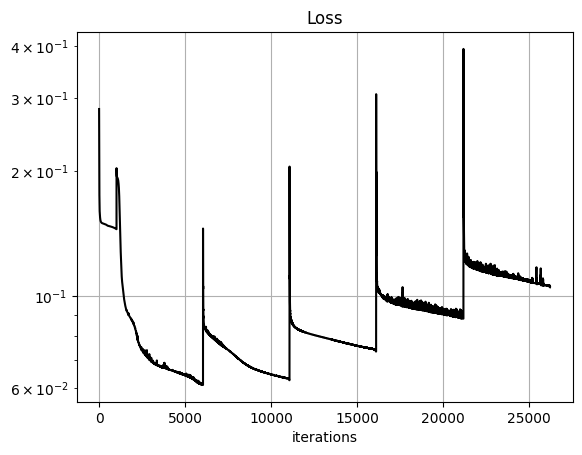

In [14]:
print (net.losses[-1], len(net.losses))
plt.semilogy(net.losses, c='black')
plt.title('Loss')
plt.xlabel('iterations')
plt.grid()
# plt.ylim(0,1)0.03445291519165039

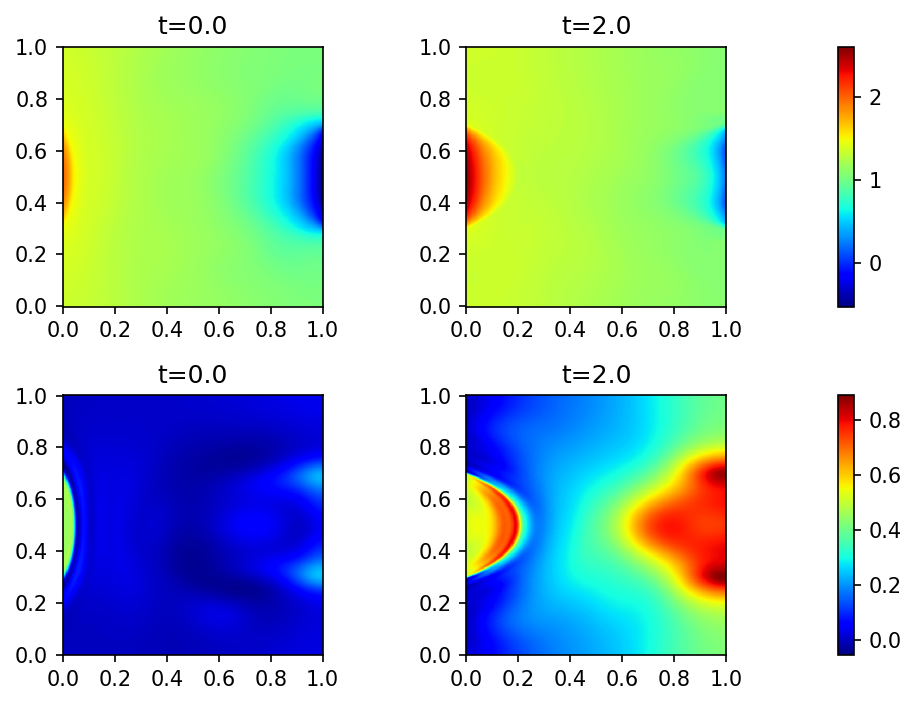

In [15]:
Nx = 500
Ny = 500
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
t = np.linspace(t_min, t_max, 60)
X, Y = np.meshgrid(x,y)
# net.full_load("data\CL_w,[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]/0.0318",
            #   "data\CL_w,[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]/0.0318_data.npy")
# net.full_load("data\CL_w,[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]/0.25",
            #   "data\CL_w,[1, 0.694, 0.51, 0.39, 0.308, 0.25, 0.207, 0.173, 0.148, 0.128, 0.111]/0.25_data.npy")
net.model.eval()
outputs = vis.plot_results(x_min, x_max, y_min, y_max, t_max, net, Nx, Ny)#,clims=[0.4,0.7,0,1])

ValueError: x and y must have same first dimension, but have shapes (250000, 1) and (500,)

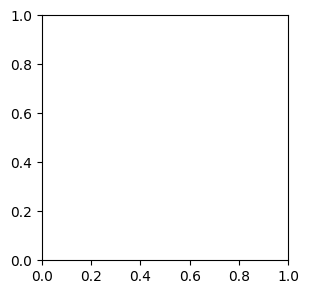

In [60]:
vis.plot_BC(u_x, x, y, L/(Nx-1), H/(Ny-1), [1,1,0,0])
print (np.max(cond))
print (net.p_cond[0][2].min().item())
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, net.p_cond[0][3].min().item(), 0))
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, cond, 0))
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, cin, 0))
print(np.max(outputs[2]))
# plt.plot(x,outputs[2][:,-1])
# print ((L/(Nx-1)))

In [15]:
N = 60
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)

pt_x = torch.autograd.Variable(torch.from_numpy(x).float(), requires_grad=True).cuda()
pt_y = torch.autograd.Variable(torch.from_numpy(y).float(), requires_grad=True).cuda()

period = np.linspace(0, t_max, N)

all_u = []

for i in range(N):
    t = torch.full(x.shape, period[i])
    pt_t = torch.autograd.Variable(t, requires_grad=True).cuda()
    pt_u = net.model([pt_x, pt_y, pt_t])[:,0]
    u = pt_u.data.cpu().numpy()
    mesh_u = u.reshape(mesh_x.shape)
    all_u.append(mesh_u)
all_u = np.array(all_u)
print (all_u.shape)

(60, 500, 500)


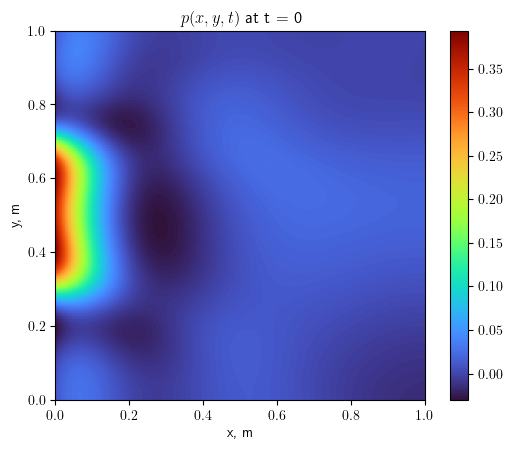

In [33]:
vis.anim_result(all_u,
                t_max/N,
                # clims=[0,0.5],
                colour='turbo',
                savetogif=True,
                showMe=True,
                )

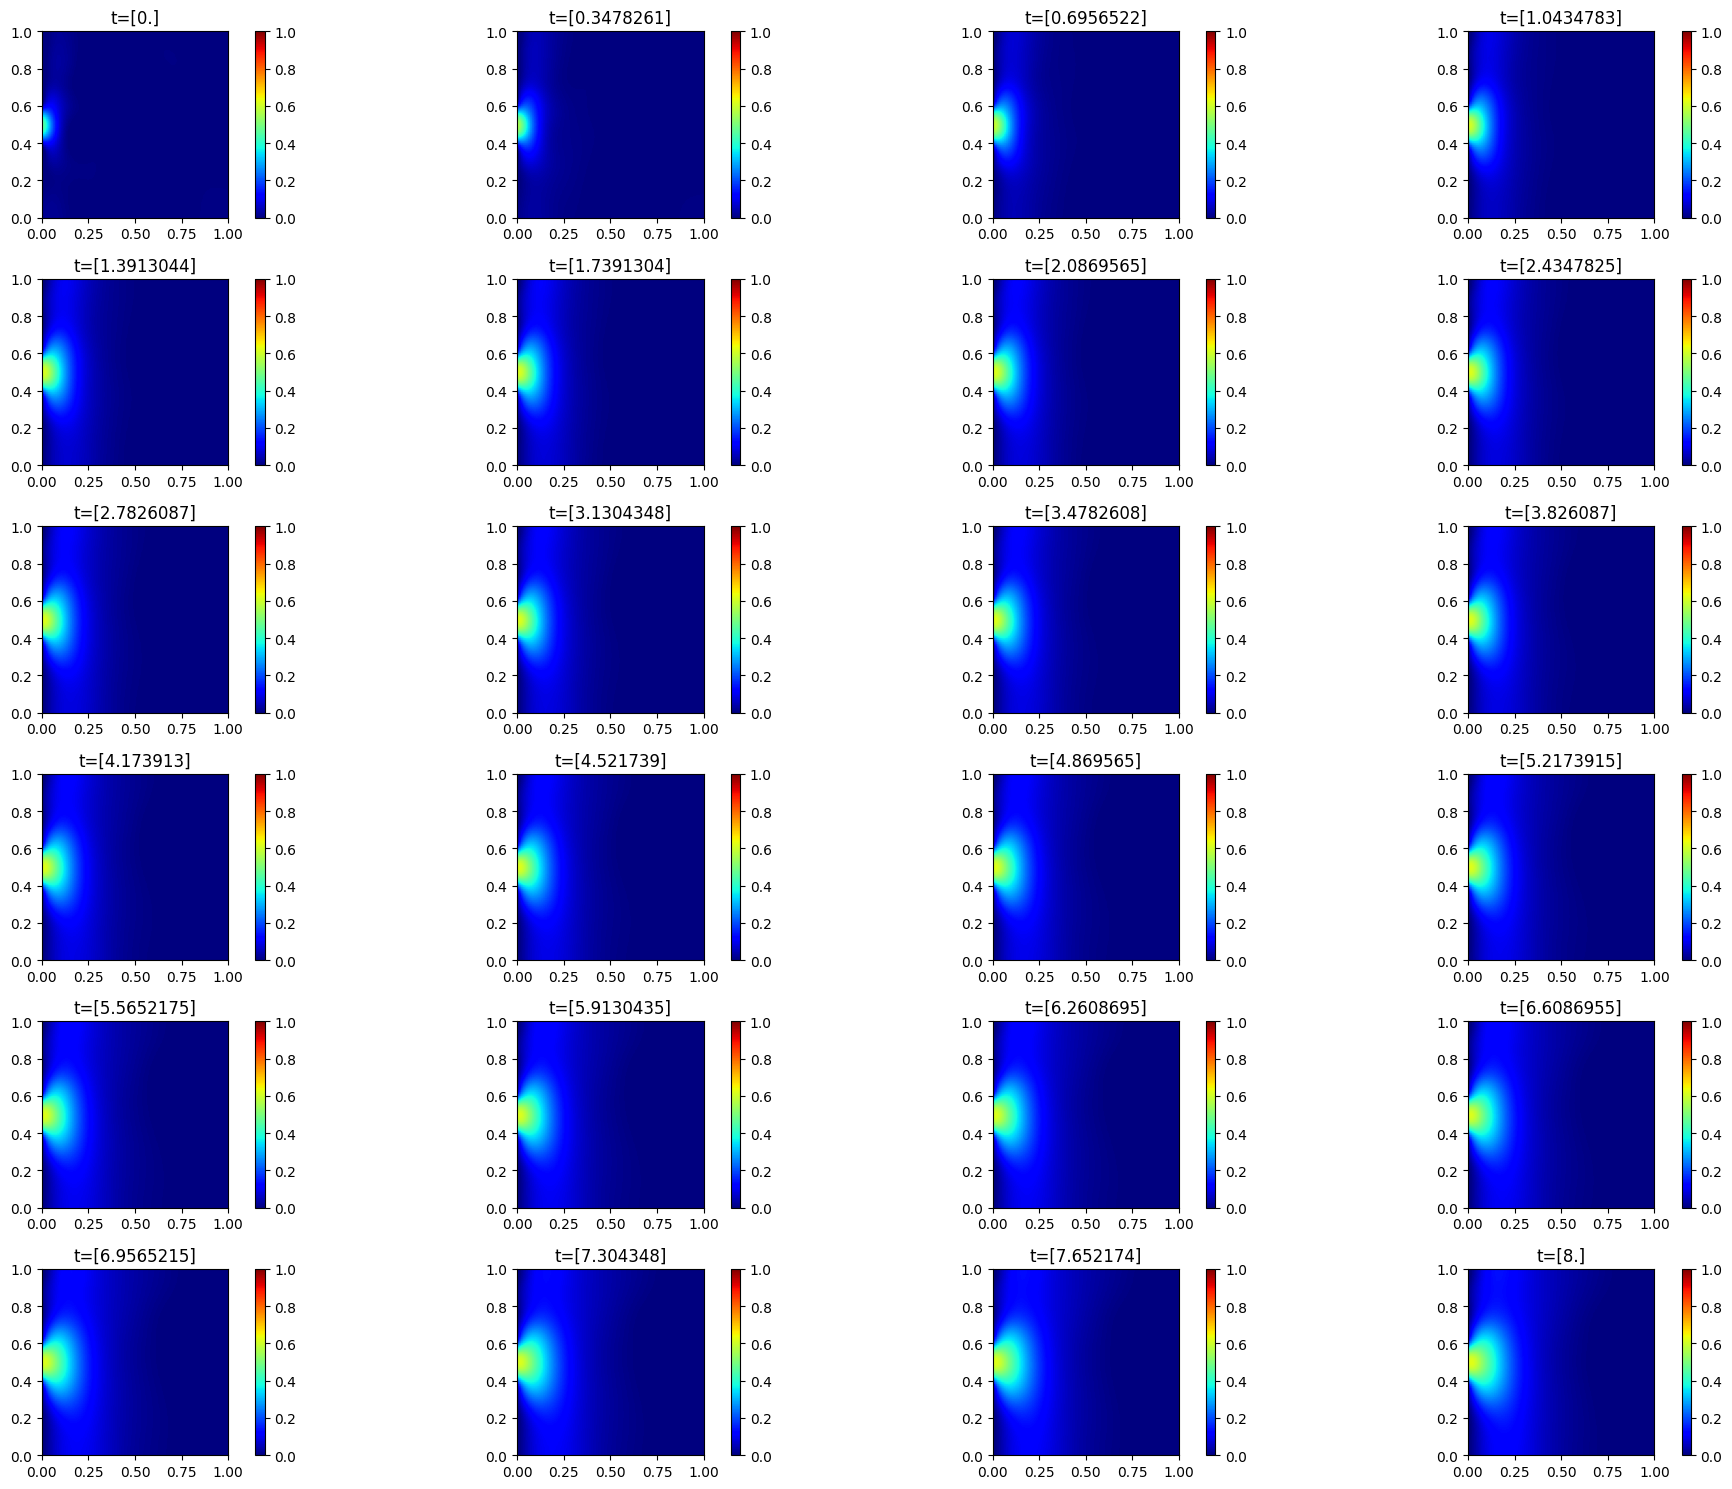

In [8]:
def plot_results(i, t_):
  x = np.arange(x_min, x_max, 0.01)
  y = np.arange(y_min, y_max, 0.01)
  
  mesh_x, mesh_y = np.meshgrid(x, y)
  x = np.ravel(mesh_x).reshape(-1, 1)
  y = np.ravel(mesh_y).reshape(-1, 1)

  pt_x = torch.autograd.Variable(torch.from_numpy(x).float(), requires_grad=True).cuda()
  pt_y = torch.autograd.Variable(torch.from_numpy(y).float(), requires_grad=True).cuda()

  period = np.linspace(0, t_, 24)

  fig, axes = plt.subplots(6, 4, figsize=(20,15))

  for index, axis in enumerate(axes.ravel()):
    t = torch.full(x.shape, period[index])
    pt_t = torch.autograd.Variable(t, requires_grad=True).cuda()
    pt_u = net.model([pt_x, pt_y, pt_t])[:,i]
    u = pt_u.data.cpu().numpy()
    mesh_u = u.reshape(mesh_x.shape)
    #cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')#, vmin=-1, vmax=1
    
    cm = axis.imshow(mesh_u, cmap='jet', extent=[x_min,x_max,y_min,y_max])#, vmin=-1, vmax=1
    fig.colorbar(cm, ax=axis)
    cm.set_clim(0, 1)
    axis.set_xlim([x_min, x_max])
    axis.set_title(f't={pt_t.data.cpu().numpy()[0]}')
    # axis.set_xticks([])
    # axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
  fig.tight_layout()
  plt.show()
plot_results(1, t_max)